## Pull TIMS from S3

##### June 17, 2019

In this notebook, we are prototyping code to get the TIMS data from the S3 bucket 

In [3]:
import pandas as pd
import numpy as np
import sys, os
import boto3
import pyproj
import datetime
import re
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline
basepath = os.getcwd() #path of current script

List TIMS data from S3

In [4]:
s3_session = boto3.Session(profile_name='dssg')
bucket_name = 'air-pollution-uk'

s3_resource = s3_session.resource('s3')

my_bucket = s3_resource.Bucket(bucket_name)
objects = my_bucket.objects.filter(Prefix="raw/tims_data/")


#### Check number of CSVs pulled per month

Speculation: All the csvs are pulled for the 1st day of each month. 

In [13]:
# selected_files = []
filepaths = [obj.key for obj in objects]
datecounter_dict = defaultdict(int)

for fp in filepaths:
    #get dates for each fp
    filename = fp.split("/")[-1]
    if filename.startswith("detdata"):
        date_str = re.search("(detdata)([0-9]*)", filename).group()
        datecounter_dict[date_str] +=1
    
dates = []
counts = []
for key in datecounter_dict: 
    #recall dmy
    dd, mm,YYYY = key[0:2], key[2:4], key[4:]
    formatted_date = YYYY + "-" + mm + "-" + dd
    dates.append(formatted_date)
    counts.append(datecounter_dict[key])


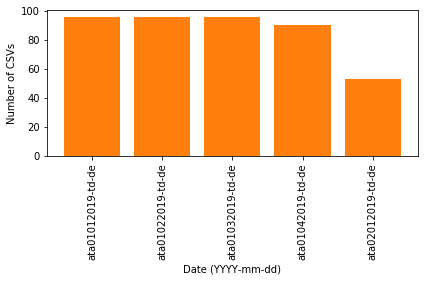

In [12]:
plt.figure()
plt.bar(np.arange(len(dates)), counts)
plt.bar(dates, counts)

plt.xticks(np.arange(len(dates)), dates, rotation='vertical')
plt.xlabel('Date (YYYY-mm-dd)')
plt.ylabel('Number of CSVs')
plt.tight_layout()
# plt.savefig(os.path.join(os.path.dirname(os.path.realpath(__file__)),
#                                   '..', '..', 'plots/01_exploratory/s3_description.pdf'))
plt.show()
plt.close()



#### Look at a csv from the S3 Bucket 

In [40]:
#check a csv 
s3_client = s3_session.client('s3')
csv_obj = s3_client.get_object(Bucket=bucket_name, Key='raw/tims_data/detdata01042019-213027.csv')
initial_df = pd.read_csv(csv_obj['Body']) # 'Body' is a key word
initial_df.head()

,TIMESTAMP,NODE,EASTING,NORTHING,FLOW_ACTUAL_15M,SAT_BANDINGS,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
0,2019-04-01T20:21:00Z,10/114,528894.67,177070.33,211,0-79%,4,4,1.0
1,2019-04-01T20:21:00Z,10/115,528385.87,173071.87,382,0-79%,1,1,1.0
2,2019-04-01T20:21:00Z,10/116,528399.50,173073.96,407,0-79%,1,1,1.0
3,2019-04-01T20:21:00Z,10/117,528294.39,172880.22,226,0-79%,2,2,1.0
4,2019-04-01T20:21:00Z,10/118,528306.71,172882.36,444,0-79%,1,1,1.0


### Get CSVs between certain date range 

In [33]:
def retrieve_tims_from_s3(from_date='2019-06-01', to_date=str(datetime.datetime.now())[:10]):
    #typecast from and to dates 
    from_YYYY, from_mm, from_dd = from_date.split("-")
    from_date = datetime.date(year = int(from_YYYY), month = int(from_mm), day = int(from_dd))
    to_YYYY, to_mm, to_dd = to_date.split("-")
    to_date = datetime.date(year = int(to_YYYY), month = int(to_mm), day = int(to_dd))

    #names and paths 
    bucket_name = 'air-pollution-uk'
    tims_path = 'raw/tims_data/' 

    #setup s3 retrieval with boto3
    s3_session = boto3.Session(profile_name='dssg')
    s3_client = s3_session.client('s3')
    s3_resource = s3_session.resource('s3')

    my_bucket =  s3_resource.Bucket(bucket_name)

    #get names of all tims files in s3 based on provided dates
    objects = my_bucket.objects.filter(Prefix=tims_path)

    # Get list of files in s3 based on dates provided

    selected_files = []
    filepaths = [obj.key for obj in objects]
    for fp in filepaths:
        #get dates for each fp
        filename = fp.split("/")[-1]
        date_str = re.search("(detdata)([0-9]*)", filename).group(2)
        dd, mm, YYYY = "", "", ""
        dd, mm,YYYY = int(dd.join(date_str[0:2])), int(mm.join(date_str[2:4])), int(YYYY.join(date_str[4:]))
        filedate = datetime.date(year=YYYY, month=mm, day=dd )

        if (filedate >= from_date and filedate <= to_date):
            selected_files.append(fp)


    #loop through selected files, retrieve csv obj from S3 bucket using the selected filepaths
    df_list = []
    for fp in selected_files: 
        csv_obj = s3_client.get_object(Bucket=bucket_name, Key=fp)
        #convert to pandas df
        df_list.append(pd.read_csv(csv_obj['Body'])) 


    return pd.concat(df_list)


In [35]:
df_all = retrieve_tims_from_s3(from_date='2019-01-01')
df_all.head()

,TIMESTAMP,NODE,EASTING,NORTHING,FLOW_ACTUAL_15M,SAT_BANDINGS,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
0,2018-12-31T23:48:00Z,09/017,529375.89,175212.75,304,0-79%,8,8,1.0
1,2018-12-31T23:47:00Z,09/017,529375.89,175212.75,303,0-79%,8,8,1.0
2,2018-12-31T23:46:00Z,09/017,529375.89,175212.75,314,0-79%,8,8,1.0
3,2018-12-31T23:45:00Z,09/017,529375.89,175212.75,322,0-79%,8,8,1.0
4,2018-12-31T23:44:00Z,09/017,529375.89,175212.75,334,0-79%,8,8,1.0


In [38]:
df_all.shape

(17814774, 9)